In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)
print("All libraries imported successfully.")

All libraries imported successfully.


In [10]:
csv_path = "data/data_processed/final_predictions.csv"
assert os.path.exists(csv_path), f"File not found: {csv_path}"
df = pd.read_csv(csv_path)
print(f"Loaded dataset with shape: {df.shape}")
print("Columns:", df.columns.tolist())
print("Label distribution:\n", df["label"].value_counts())
print("First few rows:\n", df.head())


Loaded dataset with shape: (5, 9)
Columns: ['id', 'text', 'label', 'image_path', 'clip_score', 'suspicious', 'image_mismatch', 'similarity_to_reference', 'predicted_label']
Label distribution:
 label
real    3
fake    2
Name: count, dtype: int64
First few rows:
    id                                     text label              image_path  clip_score  suspicious  image_mismatch  similarity_to_reference predicted_label
0   0  This looks like a real flood in Kerala.  real  data/images/flood1.jpg        0.87           0               0                     0.90            real
1   1    Seems photoshopped, don't believe it.  fake   data/images/fake1.jpg        0.41           1               1                     0.30            fake
2   2        Genuine disaster response effort.  real  data/images/flood1.jpg        0.93           0               0                     0.95            real
3   3               Old photo used to mislead.  fake   data/images/fake1.jpg        0.35           1     

In [24]:
for col in ["clip_score", "similarity_to_reference", "suspicious", "image_mismatch"]:
    if col not in df.columns:
        print(f"Column '{col}' missing, defaulting to 0.")
    df[col] = df.get(col, 0).fillna(0).astype(int if col in ["suspicious", "image_mismatch"] else float)


In [22]:
print("Cleaned data preview:\n", df.head())

Cleaned data preview:
    id                                     text label              image_path  clip_score  suspicious  image_mismatch  similarity_to_reference predicted_label
0   0  This looks like a real flood in Kerala.  real  data/images/flood1.jpg        0.87           0               0                     0.90            real
1   1    Seems photoshopped, don't believe it.  fake   data/images/fake1.jpg        0.41           1               1                     0.30            fake
2   2        Genuine disaster response effort.  real  data/images/flood1.jpg        0.93           0               0                     0.95            real
3   3               Old photo used to mislead.  fake   data/images/fake1.jpg        0.35           1               1                     0.25            fake
4   4       Authentic image from news sources.  real  data/images/flood1.jpg        0.88           0               0                     0.91            real


In [15]:
features = ["clip_score", "similarity_to_reference", "suspicious", "image_mismatch"]
X = df[features]
y = df["label"]
print("Feature matrix shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature matrix shape: (5, 4)
Target distribution:
 label
real    3
fake    2
Name: count, dtype: int64


In [17]:
if len(df) < 5 or len(y.unique()) < 2:
    print("Dataset too small or only one class present. Using simple random split without stratification.")
    stratify_y = None
else:
    stratify_y = y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2 if len(df) > 5 else 0.5, random_state=42, stratify=stratify_y
)


In [18]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Model trained on multimodal features.")

Model trained on multimodal features.



 Classification Report:

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00         1
        real       1.00      1.00      1.00         2

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



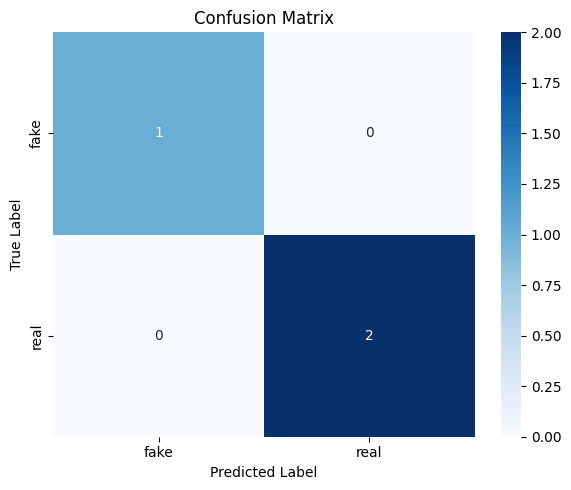

In [19]:
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Feature importances:
                    Feature  Importance
1  similarity_to_reference    0.307692
0               clip_score    0.250000
2               suspicious    0.250000
3           image_mismatch    0.192308


C:\Users\ASus\AppData\Local\Temp\ipykernel_16740\1148459416.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")


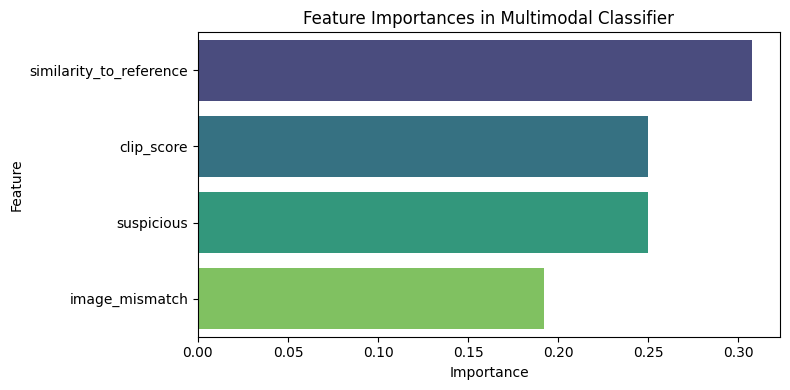

In [21]:
importances = clf.feature_importances_
feat_df = pd.DataFrame({"Feature": features, "Importance": importances})
feat_df = feat_df.sort_values(by="Importance", ascending=False)

print("Feature importances:\n", feat_df)

plt.figure(figsize=(8, 4))
sns.barplot(x="Importance", y="Feature", data=feat_df, palette="viridis")
plt.title("Feature Importances in Multimodal Classifier")
plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import roc_auc_score

# Only for binary classification
if len(np.unique(y_test)) == 2:
    y_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"🧪 ROC-AUC Score: {auc:.4f}")


🧪 ROC-AUC Score: 1.0000
